In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/30/ys2vncg97vq868_7hf19hx940000gq/T/ipykernel_41121/930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"The most recent date in the data set is {most_recent_date[0]}")

The most recent date in the data set is 2017-08-23


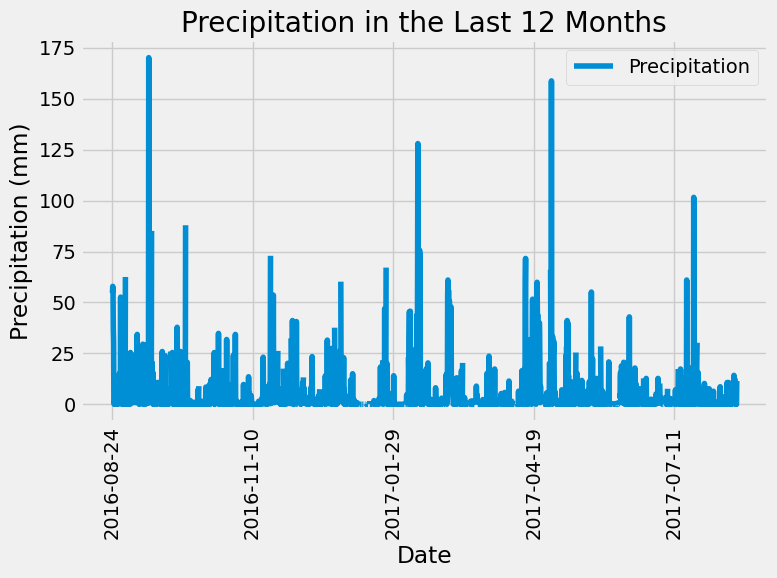

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(8, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Precipitation in the Last 12 Months")
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

# Convert the summary statistics to a DataFrame
summary_df = pd.DataFrame(summary_statistics)
summary_df

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query
most_active_station = most_active_stations[0][0]

# Calculate the lowest, highest, and average temperature.
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                     filter(Measurement.station == most_active_station).\
                     first()

# Print the temperature statistics
print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0]}")
print(f"Highest Temperature: {temperature_stats[1]}")
print(f"Average Temperature: {temperature_stats[2]}")

Temperature Statistics for Station USC00519281:
Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


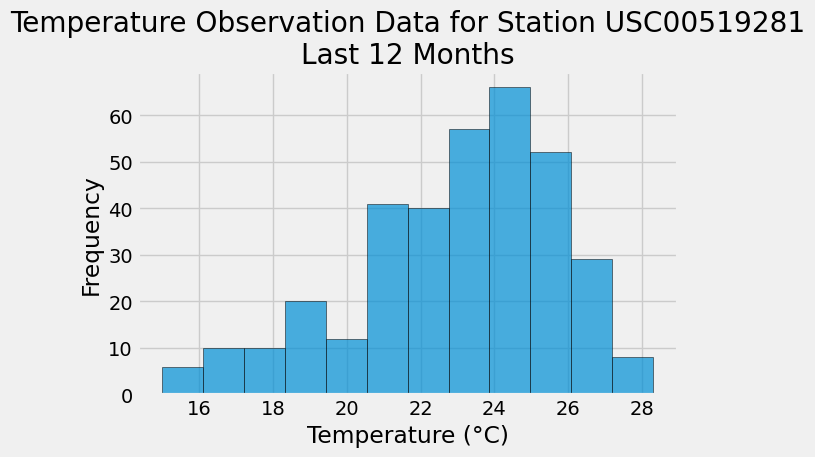

In [15]:

# Using the most active station id from the previous query
most_active_station = most_active_stations[0][0]

# Calculate the date one year from the most recent date
one_year_ago = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).\
                   filter(Measurement.station == most_active_station).\
                   filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observation Data for Station {most_active_station}\nLast 12 Months")
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()